https://www.youtube.com/watch?v=GOE__moR0eo
    
https://github.com/PatrikHlobil/PyConDe-2018---Interactive-Visualization-of-Traffic-Data-using-Bokeh/blob/master/PyConDe%202018%20-%20Interactive%20Visualization%20of%20Traffic%20Data.ipynb

In [1]:
!pip install pyshp

In [2]:
!pip install geopandas
!pip install descartes

In [1]:
#import os
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon, MultiPolygon
import matplotlib.pyplot as plt
%matplotlib inline
import random

pd.options.display.max_columns = None
pd.options.display.max_rows = None

#import seaborn as sns
#sns.set(style='whitegrid', palette='pastel', color_codes=True)
#sns.mpl.rc('figure', figsize=(10,6))

## 1. New York Taxi zones from shape file
Load an process the shapefile "taxi_zones.shp" containing the New York Taxis Zones

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,geometry
0,4,0.043567,0.000112,Alphabet City,4,"POLYGON ((-8234500.227 4971984.094, -8234502.1..."
1,12,0.036661,0.000042,Battery Park,12,"POLYGON ((-8239385.311 4968901.615, -8239356.3..."
2,13,0.050281,0.000149,Battery Park City,13,"POLYGON ((-8239027.255 4970990.635, -8239068.9..."
3,24,0.047000,0.000061,Bloomingdale,24,"POLYGON ((-8233137.952 4982697.872, -8233194.5..."
4,41,0.052793,0.000143,Central Harlem,41,"POLYGON ((-8231824.746 4984298.100, -8231526.5..."


Number of Polygons: 69


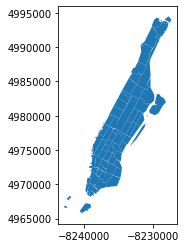

In [2]:
df_taxizones = gpd.read_file('../data/taxi_zones/taxi_zones.shp')

# filter Manhattan zones
df_taxizones = df_taxizones[df_taxizones['borough'] == 'Manhattan'].reset_index(drop=True)

df_taxizones = df_taxizones.drop(['borough'], axis=1)

df_taxizones.to_crs(epsg=3785, inplace=True)

#EPSG-Code of Web Mercador
display(df_taxizones.head())
print("Number of Polygons: %d"%len(df_taxizones))

# Simplify Shape of Zones (otherwise slow peformance of plot)
df_taxizones["geometry"] = df_taxizones["geometry"].simplify(100)
                                   
df_taxizones.plot()

Convert WKT Polygons to X and Y arrays with corresponding coordinates. Take into account multipolygons and separate them into individual shapes:

In [3]:
data = []
for zonename, LocationID, shape in df_taxizones[["zone", "LocationID", "geometry"]].values:
    #If shape is polygon, extract X and Y coordinates of boundary line:
    if isinstance(shape, Polygon):
        X, Y = shape.boundary.xy
        X = [int(x) for x in X]
        Y = [int(y) for y in Y]
        data.append([LocationID, zonename, X, Y])
        
    #If shape is Multipolygon, extract X and Y coordinates of each sub-Polygon:
    if isinstance(shape, MultiPolygon):
        for poly in shape:
            X, Y = poly.boundary.xy
            X = [int(x) for x in X]
            Y = [int(y) for y in Y]
            data.append([LocationID, zonename, X, Y])

#Create new DataFrame with X an Y coordinates separated:
df_taxizones = pd.DataFrame(data, columns=["LocationID", "ZoneName", "X", "Y"])
print("Number of Polygons: %d"%len(df_taxizones))
display(df_taxizones.head(77))

Number of Polygons: 77


,LocationID,ZoneName,X,Y
0,4,Alphabet City,"[-8234500, -8234690, -8235841, -8235196, -8234...","[4971984, 4970961, 4971345, 4972514, 4972139, ..."
1,12,Battery Park,"[-8239385, -8239229, -8239175, -8239225, -8239...","[4968901, 4968851, 4968359, 4968208, 4968705, ..."
2,13,Battery Park City,"[-8239027, -8239307, -8239625, -8239795, -8239...","[4970990, 4969577, 4968770, 4969086, 4970076, ..."
3,24,Bloomingdale,"[-8233137, -8233194, -8234622, -8234426, -8232...","[4982697, 4982598, 4983379, 4983737, 4982971, ..."
4,41,Central Harlem,"[-8231824, -8231160, -8231269, -8231495, -8231...","[4984298, 4983928, 4983731, 4983733, 4983456, ..."
5,42,Central Harlem North,"[-8230335, -8230425, -8230276, -8230853, -8230...","[4988211, 4987721, 4985757, 4984482, 4984283, ..."
6,43,Central Park,"[-8234586, -8234638, -8235599, -8232951, -8231...","[4977725, 4977634, 4978245, 4982962, 4982431, ..."
7,45,Chinatown,"[-8237364, -8236814, -8236741, -8237552, -8238...","[4970257, 4970304, 4969591, 4969358, 4969955, ..."
8,48,Clinton East,"[-8236660, -8236710, -8237342, -8236313, -8235...","[4976319, 4976228, 4976581, 4978444, 4978092, ..."
9,50,Clinton West,"[-8237272, -8236313, -8237138, -8238060, -8237...","[4978991, 4978444, 4976951, 4977532, 4977508, ..."


## 2. New York Taxi Data from ML model
For this first approach I am using **training data** but I will need to use **PREDICTED DATA**.

In [4]:
# 'df_taxis' should be a data frame returned by the ML model
df_taxis = pd.read_csv('../data/Data_Taxis_2017_Cleaned.csv', sep=',',
                      usecols=['hour','dayofweek','LocationID','NoOfPickups'])

pickups = df_taxis.groupby(['hour','dayofweek','LocationID']).sum()
print('Imported Predicted Data:', df_taxis.shape)
display(pickups.head())

Imported Predicted Data: (536306, 4)


NoOfPickups
hour dayofweek LocationID             
0    0         4                   965
               12                   68
               13                 1029
               24                  854
               41                 1468

#### Tranform predicted data frame so that it can be plotted

In [5]:
##### RUN THIS CELL ONLY ONCE. SHAPE SHOULD BE (77, 172)

#pickups = pd.DataFrame(pickups)
df_taxizones2 = pd.DataFrame()
for hour in range(24):    
    for dayofweek in range(7):
        
        #Get pickups and dropoff for this hour and weekday:
        p = pd.DataFrame(pickups.loc[(hour, dayofweek)]).reset_index().rename(columns={"LocationID" : "LocationID"})
       
        #Add information of pickups and dropoff to the New York Taxi Zone DataFrame:
        df_taxizones = pd.merge(df_taxizones, p, on="LocationID", how="left").fillna(0)
        df_taxizones.rename(columns={"NoOfPickups" : "Passenger_%d_%d"%(dayofweek, hour)}, inplace=True) 
        
print('Processed Data for Plot Input: ',df_taxizones.shape)
df_taxizones.head(2)

Processed Data for Plot Input:  (77, 172)


,LocationID,ZoneName,X,Y,Passenger_0_0,Passenger_1_0,Passenger_2_0,Passenger_3_0,Passenger_4_0,Passenger_5_0,Passenger_6_0,Passenger_0_1,Passenger_1_1,Passenger_2_1,Passenger_3_1,Passenger_4_1,Passenger_5_1,Passenger_6_1,Passenger_0_2,Passenger_1_2,Passenger_2_2,Passenger_3_2,Passenger_4_2,Passenger_5_2,Passenger_6_2,Passenger_0_3,Passenger_1_3,Passenger_2_3,Passenger_3_3,Passenger_4_3,Passenger_5_3,Passenger_6_3,Passenger_0_4,Passenger_1_4,Passenger_2_4,Passenger_3_4,Passenger_4_4,Passenger_5_4,Passenger_6_4,Passenger_0_5,Passenger_1_5,Passenger_2_5,Passenger_3_5,Passenger_4_5,Passenger_5_5,Passenger_6_5,Passenger_0_6,Passenger_1_6,Passenger_2_6,Passenger_3_6,Passenger_4_6,Passenger_5_6,Passenger_6_6,Passenger_0_7,Passenger_1_7,Passenger_2_7,Passenger_3_7,Passenger_4_7,Passenger_5_7,Passenger_6_7,Passenger_0_8,Passenger_1_8,Passenger_2_8,Passenger_3_8,Passenger_4_8,Passenger_5_8,Passenger_6_8,Passenger_0_9,Passenger_1_9,Passenger_2_9,Passenger_3_9,Passenger_4_9,Passenger_5_9,Passenger_6_9,Passenger_0_10,Passenger_1_10,Passenger_2_10,Passenger_3_10,Passenger_4_10,Passenger_5_10,Passenger_6_10,Passenger_0_11,Passenger_1_11,Passenger_2_11,Passenger_3_11,Passenger_4_11,Passenger_5_11,Passenger_6_11,Passenger_0_12,Passenger_1_12,Passenger_2_12,Passenger_3_12,Passenger_4_12,Passenger_5_12,Passenger_6_12,Passenger_0_13,Passenger_1_13,Passenger_2_13,Passenger_3_13,Passenger_4_13,Passenger_5_13,Passenger_6_13,Passenger_0_14,Passenger_1_14,Passenger_2_14,Passenger_3_14,Passenger_4_14,Passenger_5_14,Passenger_6_14,Passenger_0_15,Passenger_1_15,Passenger_2_15,Passenger_3_15,Passenger_4_15,Passenger_5_15,Passenger_6_15,Passenger_0_16,Passenger_1_16,Passenger_2_16,Passenger_3_16,Passenger_4_16,Passenger_5_16,Passenger_6_16,Passenger_0_17,Passenger_1_17,Passenger_2_17,Passenger_3_17,Passenger_4_17,Passenger_5_17,Passenger_6_17,Passenger_0_18,Passenger_1_18,Passenger_2_18,Passenger_3_18,Passenger_4_18,Passenger_5_18,Passenger_6_18,Passenger_0_19,Passenger_1_19,Passenger_2_19,Passenger_3_19,Passenger_4_19,Passenger_5_19,Passenger_6_19,Passenger_0_20,Passenger_1_20,Passenger_2_20,Passenger_3_20,Passenger_4_20,Passenger_5_20,Passenger_6_20,Passenger_0_21,Passenger_1_21,Passenger_2_21,Passenger_3_21,Passenger_4_21,Passenger_5_21,Passenger_6_21,Passenger_0_22,Passenger_1_22,Passenger_2_22,Passenger_3_22,Passenger_4_22,Passenger_5_22,Passenger_6_22,Passenger_0_23,Passenger_1_23,Passenger_2_23,Passenger_3_23,Passenger_4_23,Passenger_5_23,Passenger_6_23
0,4,Alphabet City,"[-8234500, -8234690, -8235841, -8235196, -8234...","[4971984, 4970961, 4971345, 4972514, 4972139, ...",965.0,873.0,1218.0,1574.0,2201.0,5602.0,6175.0,620.0,596.0,884.0,1057.0,1736.0,6113.0,7172.0,414.0,349.0,513.0,692.0,1206.0,5658.0,6452.0,311.0,277.0,365.0,401.0,717.0,3940.0,4666.0,355.0,307.0,359.0,458.0,662.0,2197.0,2479.0,563.0,486.0,554.0,623.0,702.0,1131.0,1035.0,1056.0,1074.0,1209.0,1204.0,1279.0,1193.0,972.0,1550.0,1732.0,1804.0,1827.0,2011.0,1293.0,1003.0,2338.0,2489.0,2602.0,2556.0,2746.0,1675.0,1171.0,1936.0,2094.0,2231.0,2263.0,2347.0,2101.0,1658.0,1557.0,1625.0,1799.0,1792.0,1880.0,1966.0,1887.0,1303.0,1275.0,1367.0,1360.0,1545.0,2015.0,1816.0,1106.0,1137.0,1182.0,1230.0,1352.0,2007.0,1766.0,1083.0,1065.0,1095.0,1153.0,1346.0,1940.0,1641.0,1025.0,1051.0,1046.0,1165,1545.0,1958.0,1731.0,885.0,1011.0,962.0,1026.0,1371.0,1808.0,1673.0,849.0,800.0,789.0,861.0,1154.0,1621.0,1387.0,1019.0,1015.0,1053.0,1195.0,1571.0,1777.0,1547.0,1185.0,1345.0,1480.0,1658.0,2094.0,2350.0,1699.0,1192.0,1394.0,1463.0,1739.0,2473.0,2739.0,1526.0,1217.0,1496.0,1533.0,1873.0,2493.0,2582.0,1630.0,1269.0,1552.0,2004.0,2112.0,2876.0,2895.0,1594.0,1308.0,1735.0,2066.0,2496.0,3476.0,3491.0,1411.0,1105.0,1489.0,2044.0,2617.0,4633.0,4725.0,1375.0
1,12,Battery Park,"[-8239385, -8239229, -8239175, -8239225, -8239...","[4968901, 4968851, 4968359, 4968208, 4968705, ...",68.0,42.0,101.0,90.0,165.0,234.0,242.0,44.0,24.0,55.0,50.0,73.0,158.0,134.0,17.0,19.0,15.0,29.0,32.0,93.0,70.0,6.0,5.0,10.0,16.0,12.0,49.0

## 3. Plot settings with Bokeh

In [21]:
from bokeh.io import output_notebook, output_file, show
from bokeh.plotting import figure
from bokeh.models import HoverTool, Select, ColumnDataSource, WheelZoomTool, LogColorMapper, LinearColorMapper, ColorBar,BasicTicker
from bokeh.palettes import Viridis256 as palette
output_notebook()

Loading BokehJS ...

#### 3.1. Define ColumnDataSource

In [12]:
# ColumnDataSource transforms the data into something that Bokeh and Java understand

df_taxizones["Passengers"] = df_taxizones["Passenger_0_7"]

source = ColumnDataSource(df_taxizones)

#### 3.2. Define ColorMapper

In [13]:
# Calculate max of passengers
max_passengers_per_hour = df_taxizones[filter(lambda x: "Passenger_" in x, df_taxizones.columns)].max().max()

color_mapper = LinearColorMapper(palette=palette[::-1], high=max_passengers_per_hour, low=0)

#### 3.3. Define ColorBar

In [22]:
##### Color Bar
color_bar = ColorBar(color_mapper = color_mapper,
                     ticker = BasicTicker(),
                    label_standoff=8,
                     location=(0,0),
                     orientation='vertical')

#### 3.3. Define Figure

In [31]:
p = figure(title="New York Taxi Pickups",
           plot_width=450, plot_height=750,
           toolbar_location=None,
           tools='pan,wheel_zoom,box_zoom,reset,save')
p.xaxis.visible = False
p.yaxis.visible = False

p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Get rid of zoom on axes:
for t in p.tools:
    if type(t) == WheelZoomTool:
        t.zoom_on_axis = False

#### 3.4. Draw taxis zones as 'Patches'

In [32]:
patches = p.patches(xs="X", ys="Y", source=source,
                  fill_color={'field': 'Passengers', 'transform': color_mapper},
                  line_color="black", alpha=0.5)
show(p)

#### 3.5. Add color bar to layout

In [33]:
p.add_layout(color_bar, 'right')

#### 3.5. Add Hover tool (use @ to access the attributes to show)

In [34]:
hovertool = HoverTool(tooltips=[('Zone:', "@ZoneName"),
                                ("Passengers:", "@Passengers")])
p.add_tools(hovertool)
show(p)

## 4. Interactivity: Slider and buttons

#### 4.1. Add slider widget for hourly periods

In [35]:
from bokeh.models.widgets import Slider, RadioButtonGroup
from bokeh.layouts import column, row, widgetbox

slider = Slider(start=0, end=23, value=7, step=1, title="Hour", width=600)

show(slider)

#### 4.2. Add radio buttons for weekday

In [36]:
radiobuttons_weekday = RadioButtonGroup(
    labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    active=0,
    width=400)

layout_widgets = column(slider, row(radiobuttons_weekday))
show(layout_widgets)

#### 4.3. Add interaction via JavaScript Callback

In [37]:
from bokeh.models.callbacks import CustomJS

#Define callback-function with JavaScript Code:
callback = CustomJS(args=dict(p=p, source=source, slider=slider,
                             radiobuttons_weekday=radiobuttons_weekday),
                    code="""
                    
//Get value of slider for hour:
var hour = slider.value;

//Get value of weekday:
var weekday = radiobuttons_weekday.active;

//Change data of "Passengers" column in data source to passenger data of the selected hour:
source.data["Passengers"] = source.data["Passenger_" + weekday + "_" + hour];
source.change.emit();
                    
                    """)

#Bind Callback to value change of slider and radiobuttons:
slider.js_on_change("value", callback)
radiobuttons_weekday.js_on_change("active", callback)

#Show all elements:
layout = column(layout_widgets, p)
show(layout)

In [17]:
layout

Column(id='1224', ...)